In [1]:
using Gmsh, TipiFEM, TipiFEM.Meshes, TipiFEM.PolytopalMesh, TipiFEM.Quadrature
using StaticArrays
using PyPlot

INFO: Recompiling stale cache file /home/tehrengruber/.julia/lib/v0.6/FileIO.ji for module FileIO.
INFO: Recompiling stale cache file /home/tehrengruber/.julia/lib/v0.6/MacroTools.ji for module MacroTools.
INFO: Recompiling stale cache file /home/tehrengruber/.julia/lib/v0.6/GaussQuadrature.ji for module GaussQuadrature.
INFO: Recompiling stale cache file /home/tehrengruber/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


# Load msh

In [36]:
msh = Gmsh.load("/home/tehrengruber/.julia/v0.6/Gmsh/assets/triangle_refined_max.msh", mesh_dim=2, world_dim=2)

INFO: Gmsh: reading 1050625 nodes
INFO: Gmsh: reading 2101251 elements


TipiFEM.Mesh at Ptr{Void} @0x00007f6ff9254580
  world dim: 2
  mesh dimension: 2
  cell types: Polytope"3-node triangle", Polytope"4-node quadrangle"
   Codim    Dim     #cells
       0      2    2097152
       1      1    3147776
       2      0    1050625
  topology: 
    → | 0  1  2
    --|--------
    0 | 0  0  0     
    1 | 1  0  0     
    2 | 1  1  1

# Setup Finite Element space

In [37]:
basis = FEBasis{:Lagrangian, 1}()
dofh=TipiFEM.DofHandler(msh, basis) # todo: pretty printer

fulltype(TipiFEM.DofHandler{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, TipiFEM.FEBasis{:Lagrangian,1}, fulltype(TipiFEM.Meshes.Mesh{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, 2, Float64})})(fulltype(TipiFEM.Meshes.Mesh{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, 2, Float64})(TipiFEM.Meshes.HomogenousMeshFunction{Polytope"1-node point",StaticArrays.SArray{Tuple{2},Float64,1,2},Base.OneTo{TipiFEM.Meshes.Index{Polytope"1-node point"}},Array{StaticArrays.SArray{Tuple{2},Float64,1,2},1}}(Base.OneTo(TipiFEM.Meshes.Index{Polytope"1-node point"}(0x0000000000100801)), StaticArrays.SArray{Tuple{2},Float64,1,2}[[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 0.344727], [0.0, 0.31543], [0.0, 0.317383], [0.0, 0.319336], [0.0, 0.321289], [0.0, 0.323242], [0.0, 0.325195]  …  [0.497559, 0.499512], [0.497559, 0.501465], [0.498047, 0.500977], [0.498047, 0.499023], [0.496582, 0.501465], [0.496582, 0.502441], [0.49707, 0.501953], [0.498535, 0.499512], [

In [38]:
using TipiFEM.Meshes.elements

In [39]:
elements(msh)

2097152 element HeterogenousMeshFunction Union{Polytope"3-node triangle", Polytope"4-node quadrangle"} → Union{fulltype(TipiFEM.Meshes.Connectivity{Polytope"3-node triangle", Polytope"1-node point"}), fulltype(TipiFEM.Meshes.Connectivity{Polytope"3-node triangle", Polytope"1-node point"})}
├─ 2097152 element HomogenousMeshFunction Polytope"3-node triangle" → fulltype(TipiFEM.Meshes.Connectivity{Polytope"3-node triangle", Polytope"1-node point"})
|  (1, TipiFEM.Meshes.Index{Polytope"1-node point"}[1, 265218, 3425])
|  (2, TipiFEM.Meshes.Index{Polytope"1-node point"}[265218, 265219, 3425])
|  (3, TipiFEM.Meshes.Index{Polytope"1-node point"}[265218, 69122, 265219])
|  (4, TipiFEM.Meshes.Index{Polytope"1-node point"}[3425, 265219, 3587])
|  (5, TipiFEM.Meshes.Index{Polytope"1-node point"}[69122, 265220, 265219])
|  (6, TipiFEM.Meshes.Index{Polytope"1-node point"}[265220, 265221, 265219])
|  (7, TipiFEM.Meshes.Index{Polytope"1-node point"}[265220, 69123, 265221])
|  (8, TipiFEM.Meshes.Index

In [48]:
@time geometry(msh)

  0.593156 seconds (4.19 M allocations: 352.001 MiB, 30.38% gc time)


2097152 element HeterogenousMeshFunction Union{Polytope"3-node triangle", Polytope"4-node quadrangle"} → Any
├─ 2097152 element HomogenousMeshFunction Polytope"3-node triangle" → fulltype(TipiFEM.Meshes.Geometry{Polytope"3-node triangle", 2, Float64})
|  (1, [0.0 0.0; 0.000488281 0.000488281; 0.000976563 0.0])
|  (2, [0.000488281 0.000488281; 0.00146484 0.000488281; 0.000976563 0.0])
|  (3, [0.000488281 0.000488281; 0.000976562 0.000976563; 0.00146484 0.000488281])
|  (4, [0.000976563 0.0; 0.00146484 0.000488281; 0.00195313 0.0])
|  (5, [0.000976562 0.000976563; 0.00195312 0.000976563; 0.00146484 0.000488281])
|  (6, [0.00195312 0.000976563; 0.00244141 0.000488281; 0.00146484 0.000488281])
|  (7, [0.00195312 0.000976563; 0.00292969 0.000976563; 0.00244141 0.000488281])
|  (8, [0.00146484 0.000488281; 0.00244141 0.000488281; 0.00195313 0.0])
|  (9, [0.000976562 0.000976563; 0.00146484 0.00146484; 0.00195312 0.000976563])
|  (10, [0.00146484 0.00146484; 0.00244141 0.00146484; 0.00195312 

In [70]:
@time mapreduce(+, geometry(msh)) do el
    volume(el)
end

  2.108295 seconds (27.27 M allocations: 1.157 GiB, 19.07% gc time)


0.5000000000001346

In [83]:
let full_mesh_geo = geometry(msh)
    @time for i = 1:1
        mapreduce(+, decompose(full_mesh_geo)) do mesh_geo
            vol = 0.
            for geo in mesh_geo
                vol += volume(geo)
            end
            vol
        end
    end
end

  0.072485 seconds (15.63 k allocations: 823.170 KiB)


In [33]:
eval(TipiFEM.Meshes, quote
function MeshFunction{II, VI}(indices::II, values::VI)
  length(size(values)) == 1 || error("MeshFunctions may only be initialized from 1-dimensional arrays")
  let K = cell_type(eltype(indices)), V = fulltype(eltype(values))
    find_appropriate_mesh_function(K, V){K, V}(indices, values)
  end
end
        end)

TipiFEM.Meshes.MeshFunction

In [4]:
# rename some functions for readability
using TipiFEM: number_of_local_shape_functions, local_shape_functions, grad_local_shape_functions

K=Polytope"3-node triangle"()
b̂ = local_shape_functions(basis, K)
grad_b̂=grad_local_shape_functions(basis, K)

3-element Array{TipiFEM.##5#6{Polytope"3-node triangle",TipiFEM.FEBasis{:Lagrangian,1},_} where _,1}:
 TipiFEM.#5
 TipiFEM.#5
 TipiFEM.#5

# Define the problem to be solved

In [5]:
using TipiFEM.PolytopalMesh.jacobian_transposed

DΦ⁻¹ = jacobian_inverse_transposed

#f(x) = x[1]*x[2]
#f(x) = sin(x[1]*x[2])
f(x) = (8π^2+1)cos(2π.*x[1]).*cos(2π.*x[2])

#a_l(i, j) = K -> integrate_local(x̂->dot(grad_b̂[i](x̂), grad_b̂[j](x̂)), K)
a_l(i, j) = K -> (integrate_local(K) do x̂
    # calculate transformed gradients
    grad_bi = DΦ⁻¹(K, x̂)*grad_b̂[i](x̂)
    grad_bj = DΦ⁻¹(K, x̂)*grad_b̂[j](x̂)
    # evaluate bilinear form
    #  todo: add material function
    dot(grad_bi, grad_bj)
end[1])
a_m(i, j) = K ->  integrate_local(K) do x̂
    dot(b̂[i](x̂), b̂[j](x̂))
end
l(i) = (K -> integrate_local(x̂->f(local_to_global(K, x̂))*b̂[i](x̂), K))
#l(i) = K -> begin
#    m̂1 = (point(ref_tria, 1)+point(ref_tria, 2))/2
#    m̂2 = (point(ref_tria, 2)+point(ref_tria, 3))/2
#    m̂3 = (point(ref_tria, 3)+point(ref_tria, 1))/2
#    m1 = local_to_global(K, m̂1)
#    m2 = local_to_global(K, m̂2)
#    m3 = local_to_global(K, m̂3)
#    
#    volume(K)/3*(f(m1)*b̂[i](m̂1)+f(m2)*b̂[i](m̂2)+f(m3)*b̂[i](m̂3))
#end

l (generic function with 1 method)

In [170]:
eval(TipiFEM, quote
 include("/home/tehrengruber/.julia/v0.6/TipiFEM/src/fe/fe.jl")
        end)

LoadError: LoadError: LoadError: [91minvalid redefinition of constant DofHandler[39m
while loading /home/tehrengruber/.julia/v0.6/TipiFEM/src/fe/dofhandler.jl, in expression starting on line 521
while loading /home/tehrengruber/.julia/v0.6/TipiFEM/src/fe/fe.jl, in expression starting on line 4

# Test calls

In [6]:
ref_tria = reference_element(Polytope"3-node triangle"())

3×2 fulltype(TipiFEM.Meshes.Geometry{Polytope"3-node triangle", 2, Float64}):
 0.0  0.0
 1.0  0.0
 0.0  1.0

In [7]:
el_lapl_matrix = TipiFEM.element_stiffness_matrix(a_l, Polytope"3-node triangle"(), basis)
map(Aij -> Aij(ref_tria), el_lapl_matrix)

3×3 StaticArrays.SArray{Tuple{3,3},Any,2,9}:
  1.0  -0.5  -0.5
 -0.5   0.5   0.0
 -0.5   0.0   0.5

In [8]:
el_mass_matrix = TipiFEM.element_stiffness_matrix(a_m, Polytope"3-node triangle"(), basis)
map(Aij -> Aij(ref_tria), el_mass_matrix)

3×3 StaticArrays.SArray{Tuple{3,3},Any,2,9}:
 0.0833333  0.0416667  0.0416667
 0.0416667  0.0833333  0.0416667
 0.0416667  0.0416667  0.0833333

In [9]:
el_vec = TipiFEM.element_load_vector(l, Polytope"3-node triangle"(), basis)
map(Vi -> Vi(ref_tria), el_vec)

3-element StaticArrays.SArray{Tuple{3},Any,1,3}:
 -0.993009
  0.253033
  0.253033

In [10]:
dofh[Index"3-node triangle"(2)]

3-element StaticArrays.MArray{Tuple{3},Int64,1,3}:
 290
  82
 706

In [11]:
using TipiFEM.LagrangianFESpace

In [12]:
geometry(msh)

2048 element HeterogenousMeshFunction Union{Polytope"3-node triangle", Polytope"4-node quadrangle"} → Any
├─ 2048 element HomogenousMeshFunction Polytope"3-node triangle" → fulltype(TipiFEM.Meshes.Geometry{Polytope"3-node triangle", 2, Float64})
|  (1, [0.0 0.0; 0.03125 0.0; 0.0 0.03125])
|  (2, [0.03125 0.0; 0.0625 0.0; 0.03125 0.03125])
|  (3, [0.0 0.03125; 0.03125 0.03125; 0.0 0.0625])
|  (4, [0.03125 0.03125; 0.0 0.03125; 0.03125 0.0])
|  (5, [0.0625 0.0; 0.09375 0.0; 0.0625 0.03125])
|  (6, [0.09375 0.0; 0.125 0.0; 0.09375 0.03125])
|  (7, [0.0625 0.03125; 0.09375 0.03125; 0.0625 0.0625])
|  (8, [0.09375 0.03125; 0.0625 0.03125; 0.09375 0.0])
|  (9, [0.0 0.0625; 0.03125 0.0625; 0.0 0.09375])
|  (10, [0.03125 0.0625; 0.0625 0.0625; 0.03125 0.09375])
...
├─ 0 element HomogenousMeshFunction Polytope"4-node quadrangle" → Any


# Solve the problem

## Assemble galerkin matrix

In [13]:
m1=TipiFEM.matrix_assembler(a_l, msh, basis, dofh)
m2=TipiFEM.matrix_assembler(a_m, msh, basis, dofh)
#m1[1:10, 1:10]
m=m1+m2

1089×1089 SparseMatrixCSC{Float64,Int64} with 7361 stored entries:
  [1   ,    1]  =  1.00008
  [290 ,    1]  =  -0.499959
  [291 ,    1]  =  -0.499959
  [2   ,    2]  =  1.00016
  [292 ,    2]  =  8.13802e-5
  [293 ,    2]  =  -0.499959
  [294 ,    2]  =  -0.499959
  [3   ,    3]  =  1.00008
  [295 ,    3]  =  -0.499959
  [296 ,    3]  =  -0.499959
  ⋮
  [699 , 1088]  =  -0.999919
  [1087, 1088]  =  -0.999919
  [1088, 1088]  =  4.00049
  [1089, 1088]  =  8.13802e-5
  [288 , 1089]  =  -0.999919
  [289 , 1089]  =  -0.999919
  [704 , 1089]  =  -0.999919
  [705 , 1089]  =  8.13802e-5
  [1087, 1089]  =  -0.999919
  [1088, 1089]  =  8.13802e-5
  [1089, 1089]  =  4.00049

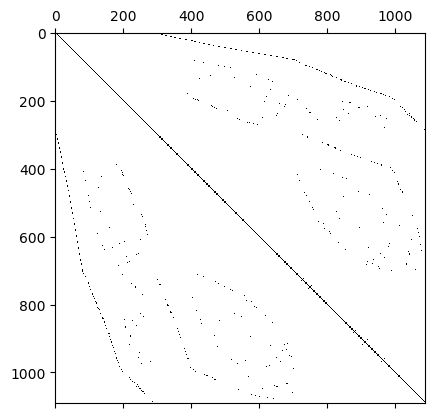

PyObject <matplotlib.image.AxesImage object at 0x7f6fcae33550>

In [14]:
# display non zero elements in the galerkin matrix
spy(m)

In [15]:
# Assemble right hand side
v=TipiFEM.vector_assembler(l, msh, basis, dofh)
v[1:10]

10-element Array{Float64,1}:
  0.0129637 
  0.0258277 
  0.0129637 
  0.0258277 
 -0.0387914 
 -0.0387914 
  0.0775827 
 -0.0387914 
 -0.0387914 
  0.00126699

In [16]:
#m[1, :]=0
#m[1, 1]=1
#v[1]=1

In [17]:
#collect(m)

In [18]:
μ = m\v

1089-element Array{Float64,1}:
  0.986156  
  1.00766   
  0.986156  
  1.00766   
 -0.996916  
 -0.996916  
  0.996909  
 -0.996916  
 -0.996916  
  0.00306963
  0.00306963
  0.00209204
 -0.00307694
  ⋮         
 -0.306636  
 -0.210776  
 -0.210491  
 -0.210491  
 -0.210776  
 -0.306636  
  0.210072  
  0.210072  
  0.305981  
  0.305981  
  0.210072  
  0.210072  

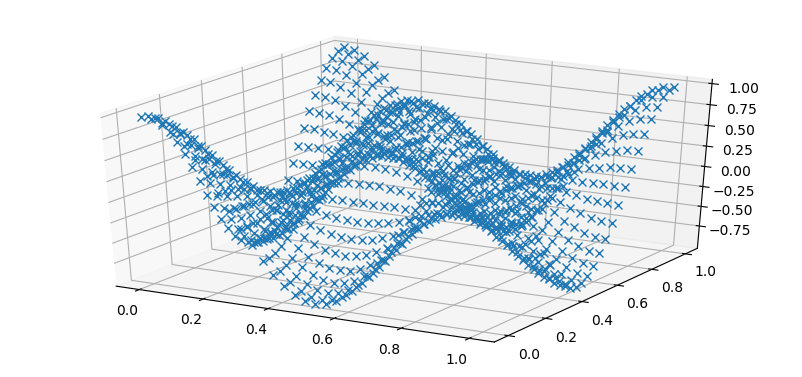

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7f6fcb3859d0>

In [19]:
# todo: missing constant somewhere. values are to low
fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](2,1,1, projection = "3d")
ax[:plot](map(x->x[1], image(msh.nodes)), map(x->x[2], image(msh.nodes)), μ, "x")

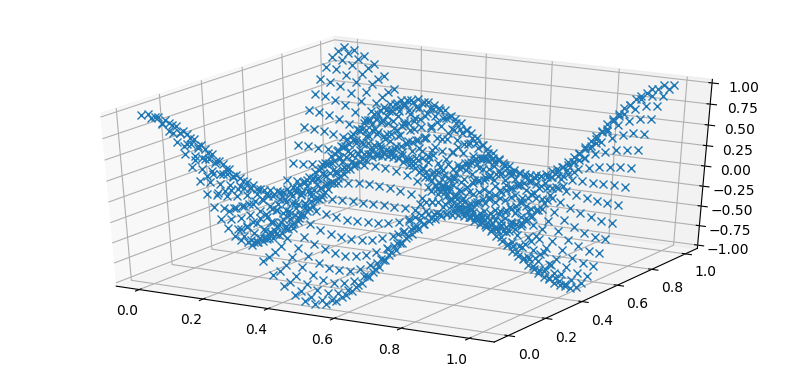

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7f45f1a386d0>

In [166]:
#u(x, y) = 1/6*x*x*x+1/6*y*y*y
#u(x, y) = 1+1/2*x*x+1/2*y*y
#u(x, y) = sin(x*y)
u(x, y) = cos(2π*x)*cos(2π*y)
fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](2,1,1, projection = "3d")
ax[:plot](map(x->x[1], image(msh.nodes)), map(x->x[2], image(msh.nodes)), image(map(x->u(x[1], x[2]), msh.nodes)), "x")

In [54]:
map(x->u(x[1], x[2]), msh.nodes)

25 element HomogenousMeshFunction Polytope"1-node point" → Float64
(1, 0.0)
(2, 0.0)
(3, 0.0)
(4, 0.0)
(5, 0.0)
(6, 0.0)
(7, 0.24740395925452294)
(8, 0.18640329676185627)
(9, 0.1864032967626835)
(10, 0.1091570568750085)
...
